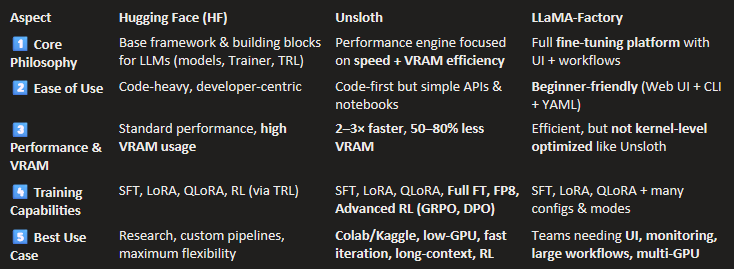

In [ ]:
!pip install torch torchvision torchaudio xformers --index-url https://download.pytorch.org/whl/cu128
!pip install unsloth
!pip install transformers==4.56.2
!pip install --no-deps trl==0.22.2

In [ ]:
# =========================
# Config
# =========================
import random
import numpy as np
import torch

SEED = 3407
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

# Faster & stable matmul on NVIDIA GPUs
torch.backends.cuda.matmul.allow_tf32 = True
torch.set_float32_matmul_precision("high")

max_seq_length = 4096        # Demonstrates long-context + RoPE scaling
dtype = None                # Auto-detect (FP16 on T4, BF16 on A100/L4)
load_in_4bit = True         # Memory-efficient QLoRA-style loading

In [ ]:
# GPU sanity check
assert torch.cuda.is_available(), "Please enable GPU runtime (Colab → Runtime → GPU)"

In [ ]:
# =========================
# Imports
# =========================
from unsloth import FastLanguageModel
from datasets import load_dataset
from trl import SFTTrainer, SFTConfig

In [ ]:
# =========================
# Load Base Model
# =========================
"""
We load a pre-quantized 4-bit TinyLlama model provided by Unsloth.
Benefits:
- Very low VRAM usage
- Fast download
- Perfect for Colab / Kaggle / 8–16GB GPUs
"""
BASE_MODEL_NAME = "unsloth/tinyllama-bnb-4bit"

model, tokenizer = FastLanguageModel.from_pretrained(
    model_name=BASE_MODEL_NAME,
    max_seq_length=max_seq_length,  # Enables long-context via RoPE scaling
    dtype=dtype,                    # Auto FP16 / BF16
    load_in_4bit=load_in_4bit,      # QLoRA-style memory efficiency
)

In [ ]:
# =========================
# Apply LoRA Adapters (PEFT)
# =========================
"""
We attach LoRA adapters so that:
- Only ~1–10% parameters are trained
- Base model weights remain frozen
- Training becomes faster and memory efficient

Target modules:
- q_proj, k_proj, v_proj, o_proj → Attention
- gate_proj, up_proj, down_proj → MLP
"""

model = FastLanguageModel.get_peft_model(
    model,
    r=32,                            # LoRA rank (8/16/32/64 are common)
    target_modules=[
        "q_proj", "k_proj", "v_proj", "o_proj",
        "gate_proj", "up_proj", "down_proj"
    ],
    lora_alpha=32,                   # Usually = r or 2*r
    lora_dropout=0.0,                # Unsloth recommends 0
    bias="none",                     # Best practice for LoRA
    use_gradient_checkpointing=False,# Set True if model >= 7B
    random_state=3407,               # Reproducibility
)


In [ ]:
# =========================
# Dataset Preparation (Alpaca Format)
# =========================
"""
We convert raw Alpaca data into a single 'text' field.
IMPORTANT:
- EOS token is mandatory, otherwise generation may never stop.
"""

alpaca_prompt = """Below is an instruction that describes a task, paired with an input that provides further context.
Write a response that appropriately completes the request.

### Instruction:
{}

### Input:
{}

### Response:
{}"""

EOS_TOKEN = tokenizer.eos_token

def format_data(examples):
    texts = []
    for instruction, input_text, output in zip(
        examples["instruction"],
        examples["input"],
        examples["output"],
    ):
        text = alpaca_prompt.format(
            instruction,
            input_text,
            output
        ) + EOS_TOKEN
        texts.append(text)
    return {"text": texts}

# Load dataset
dataset = load_dataset("yahma/alpaca-cleaned", split="train")

# Shuffle + small subset for fast demo training
dataset = dataset.shuffle(seed=3407).select(range(1500))

# Apply formatting
dataset = dataset.map(
    format_data,
    batched=True,
    remove_columns=dataset.column_names,  # keep only 'text'
)


In [ ]:
!pip install psutil

import time, psutil
# Reset GPU stats
torch.cuda.empty_cache()
torch.cuda.reset_peak_memory_stats()
# CPU RAM tracker
process = psutil.Process()
train_start_time = time.time()
cpu_ram_before = process.memory_info().rss / 1024**3  # GB


In [ ]:
# =========================
# Supervised Fine-Tuning (SFT)
# =========================
"""
We use TRL's SFTTrainer with Unsloth optimizations.
Key features:
- Sequence packing → better GPU utilization
- 8-bit optimizer → lower VRAM usage
- Gradient accumulation → simulates larger batch size
"""

trainer = SFTTrainer(
    model=model,
    tokenizer=tokenizer,
    train_dataset=dataset,
    dataset_text_field="text",
    packing=True,  # Packs multiple short samples into one sequence
    args=SFTConfig(
        per_device_train_batch_size=2,
        gradient_accumulation_steps=4,  # Effective batch size = 8
        num_train_epochs=1,
        learning_rate=2e-5,
        warmup_ratio=0.1,               # Stabilizes early training
        optim="adamw_8bit",             # Memory efficient optimizer
        logging_steps=10,               # Progress visibility
        seed=3407,                      # Reproducibility
        output_dir="outputs",
        report_to="none",               # Disable WandB by default
    ),
)

trainer.train()


In [ ]:
train_end_time = time.time()
cpu_ram_after = process.memory_info().rss / 1024**3  # GB

training_time_sec = round(train_end_time - train_start_time, 2)
peak_gpu_vram_gb = round(torch.cuda.max_memory_reserved() / 1024**3, 3)
cpu_ram_used_gb = round(cpu_ram_after - cpu_ram_before, 3)

print("===== UNSLOTH TRAINING STATS =====")
print(f"Training time (sec): {training_time_sec}")
print(f"Peak GPU VRAM (GB): {peak_gpu_vram_gb}")
print(f"CPU RAM used (GB): {cpu_ram_used_gb}")


In [ ]:
# =========================
# Inference (Fast Generation)
# =========================
"""
Unsloth provides 2× faster inference using optimized kernels.
IMPORTANT:
- Always call FastLanguageModel.for_inference(model)
- Disable gradients for inference
"""

FastLanguageModel.for_inference(model)

prompt = alpaca_prompt.format(
    "Continue the Fibonacci sequence",
    "1, 1, 2, 3, 5, 8",
    ""
)

inputs = tokenizer(
    prompt,
    return_tensors="pt"
).to("cuda")

with torch.no_grad():
    outputs = model.generate(
        **inputs,
        max_new_tokens=64,
        use_cache=True,     # Faster decoding
        do_sample=False     # Deterministic output for demo
    )

print(tokenizer.decode(outputs[0], skip_special_tokens=True))


In [ ]:
# FastLanguageModel.for_inference(model)

# prompt = "Explain LoRA in very simple words."
# inputs = tokenizer(prompt, return_tensors="pt").to("cuda")

# torch.cuda.synchronize()
# t0 = time.time()

# with torch.no_grad():
#     outputs = model.generate(
#         **inputs,
#         max_new_tokens=128,
#         use_cache=True,
#         do_sample=False
#     )

# torch.cuda.synchronize()
# t1 = time.time()

# generated_tokens = outputs.shape[-1]
# tokens_per_sec = round(generated_tokens / (t1 - t0), 2)

# print("===== INFERENCE STATS =====")
# print(f"Generated tokens: {generated_tokens}")
# print(f"Tokens per second: {tokens_per_sec}")


In [ ]:
# =========================
# Save LoRA Adapters
# =========================
"""
This saves ONLY the LoRA adapters, not the full base model.
Benefits:
- Very small size (~50–200 MB)
- Can be merged later into FP16 / 4-bit / GGUF
- Easy to share or version-control
"""

LORA_SAVE_PATH = "lora_model"

model.save_pretrained(LORA_SAVE_PATH)
tokenizer.save_pretrained(LORA_SAVE_PATH)

print(f"LoRA adapters saved at: {LORA_SAVE_PATH}")


In [ ]:
# Hugging Face baseline (NO Unsloth)

# model_name = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"

# HF Transformers
# bitsandbytes 4-bit
# PEFT LoRA
# Standard PyTorch kernels

In [ ]:
# Unsloth benchmark

# model_name = "unsloth/tinyllama-bnb-4bit"

# Same base TinyLlama
# But:
# Pre-quantized
# Triton kernels
# Manual autograd
# Auto packing
# Faster attention

In [ ]:
# When NOT to use Unsloth:
# - If you need heavy multi-node distributed training
# - If you want no-code UI only (LLaMA-Factory better)
# - If training classical ML models (not LLMs)
